In [1]:
import pysam
import numpy as np
from scipy.stats import beta

In [124]:
# Parameters for simulation
n_variants = 450  # Number of homoplasmic variant positions to simulate
coverage = 500  # Depth per variant position
mix_ratio = 0.995  # Proportion of A in the mixture

In [125]:
# Function to simulate VAFs for a sample
def simulate_sample_vafs(n_variants, coverage, alt_allele_prob=1.0):
    alt_reads = np.random.binomial(coverage, alt_allele_prob, n_variants)
    vafs = alt_reads / coverage
    return vafs

# Simulate VAFs for samples A and B (pure homoplasmic)
vafs_A = simulate_sample_vafs(n_variants, coverage, alt_allele_prob=1.0)
vafs_B = simulate_sample_vafs(n_variants, coverage, alt_allele_prob=0.0)  # All reference

# Simulate VAFs for sample AB (mixture of A and B)
vafs_AB = mix_ratio * vafs_A + (1 - mix_ratio) * vafs_B

# Add noise and clip the values to keep them within [0, 1]
noise = np.random.normal(0, 0.01, n_variants)  # Gaussian noise with mean 0 and std 0.01
vafs_AB_noisy = np.clip(vafs_AB + noise, 0, 1)

In [126]:
vafs_AB_noisy

array([0.97525959, 0.98762158, 0.98648291, 0.99230105, 0.99709123,
       0.97633875, 0.99586523, 0.99696083, 0.98790572, 0.99600271,
       0.98843782, 1.        , 0.98987542, 1.        , 0.9971564 ,
       0.98616958, 1.        , 0.98989217, 0.99415484, 1.        ,
       0.99448174, 1.        , 1.        , 0.99982316, 1.        ,
       0.99237445, 1.        , 1.        , 0.99095126, 0.9806193 ,
       0.98434069, 1.        , 0.98853218, 0.98945728, 0.99803039,
       0.99623198, 0.97755072, 1.        , 0.98586298, 0.97168351,
       0.99602796, 0.99209795, 0.99674413, 1.        , 0.98957462,
       1.        , 0.99477669, 0.99707708, 0.98835515, 0.99666868,
       0.99414606, 0.99944196, 0.99946308, 0.98869998, 0.98587784,
       0.98369932, 0.98715984, 0.99117282, 0.98899742, 1.        ,
       0.99503727, 0.99056208, 0.98790857, 0.99196534, 0.99918037,
       0.99056794, 0.99106952, 1.        , 1.        , 0.98778047,
       0.98953351, 1.        , 0.99901986, 0.99446702, 0.98875

In [127]:
# Function to assess mixture hypothesis using the Bayesian approach
def assess_mixture(vafs_AB, vafs_A, vafs_B, mix_ratio, coverage):
    posterior_probs = []
    for vaf_ab, vaf_a, vaf_b in zip(vafs_AB, vafs_A, vafs_B):
        # Calculate likelihoods under H0 and H1 using Beta distribution
        lh0 = beta.pdf(vaf_ab, vaf_a * coverage + 1, (1 - vaf_a) * coverage + 1)
        lh1 = beta.pdf(vaf_ab, 
                       mix_ratio * vaf_a * coverage + (1 - mix_ratio) * vaf_b * coverage + 1,
                       mix_ratio * (1 - vaf_a) * coverage + (1 - mix_ratio) * (1 - vaf_b) * coverage + 1)
        
        # Prior for H1 (mixture)
        prior_h1 = 0.01
        posterior_h1 = (lh1 * prior_h1) / (lh0 * (1 - prior_h1) + lh1 * prior_h1)
        posterior_probs.append(posterior_h1)
    
    return np.array(posterior_probs)

In [128]:
# Assess mixture hypothesis
posterior_probs = assess_mixture(vafs_AB_noisy, vafs_A, vafs_B, mix_ratio, coverage)

# Output: Report if mixture is detected based on posterior probabilities
threshold = 0.995  # Threshold for detecting a mixture
is_mixture = np.any(posterior_probs > threshold)

print(f"Is the simulated sample AB detected as a mixture? {'Yes' if is_mixture else 'No'}")


Is the simulated sample AB detected as a mixture? No


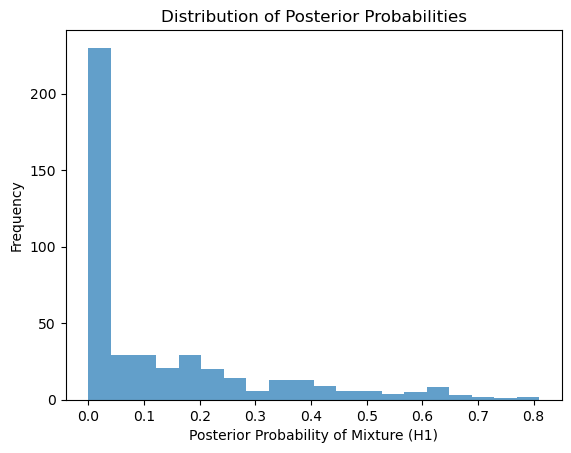

In [129]:
# Optional: Visualize the distribution of posterior probabilities
import matplotlib.pyplot as plt
plt.hist(posterior_probs, bins=20, alpha=0.7)
plt.xlabel("Posterior Probability of Mixture (H1)")
plt.ylabel("Frequency")
plt.title("Distribution of Posterior Probabilities")
plt.show()